In [1]:
import sys
from pathlib import Path

# Get the current notebook's directory
parent = Path().resolve()  # Current working directory (notebook's directory)
root = parent.parent.parent       # Go one level up

print("Current Directory:", parent)
print("Parent Directory:", root)

# Optionally append to sys.path
sys.path.append(str(root))
from indirect_identification.armax import ARMAX
from indirect_identification.d_tfs import d_tfs
import numpy as np
from scipy import signal, optimize
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull

from search.hull_helpers import expand_convex_hull, compare_hulls


# Get the current notebook's directory
parent = Path().resolve()  # Current working directory (notebook's directory)
root = parent.parent.parent       # Go one level up

print("Current Directory:", parent)
print("Parent Directory:", root)

# Optionally append to sys.path
sys.path.append(str(root))

Current Directory: C:\Users\Jake\Learning-Dynamic-Systems\search\notebooks
Parent Directory: C:\Users\Jake\Learning-Dynamic-Systems
Current Directory: C:\Users\Jake\Learning-Dynamic-Systems\search\notebooks
Parent Directory: C:\Users\Jake\Learning-Dynamic-Systems


## Setup

In [2]:
def get_construct_ss_from_params_method(n_states: int, n_inputs: int, n_outputs: int, C: np.array):
    """
    Returns the function to construct state space matrices from parameters.
    """

    def _construct_ss_from_params(params: np.array):
        """
        Returns state space matrices A_obs,B_obs,C_obs,D_obs and the A,B polynomials
        """
        # A: n_state x n_state matrix
        A =  params[:n_states]
        A_obs = np.hstack([np.vstack([np.zeros(n_states-1), np.eye(n_states-1)]), -np.flipud(A.reshape(A.size,-1))])
        # B: n_state x n_input matrix
        B = params[n_states:n_states+n_states*n_inputs].reshape(n_inputs,n_states)
        B_obs = np.flipud(B.T)
        # C: n_output x n_state matrix
        C_obs = C
        # D: n_output x n_input matrix: zero matrix for now
        D_obs = np.zeros((n_outputs,n_inputs))

        A = np.hstack([1, A])
        B = np.hstack([np.zeros((n_inputs,1)), B])

        return A_obs, B_obs, C_obs, D_obs, A, B
    return _construct_ss_from_params

In [ ]:

from search.test_systems import OpenLoop1, OpenLoop2, ClosedLoop1, ClosedLoop2, a1_true, a2_true, b1_true, b2_true
from search.search import SPSSearch
from indirect_identification.sps_indirect import SPS_indirect_model
from indirect_identification.tf_methods.fast_tfs_methods_fast_math import _is_stable
from indirect_identification.d_tfs import d_tfs, apply_tf_matrix
from dB.sim_db import SPSType
from scipy import optimize

# from indirect_identification.sps_utils import get_construct_ss_from_params_method
n_samples = 1000

IS_VERBOSE = False

# Initialise SPS
m = 100
q = 5
n = 100

armax_model = OpenLoop1
n_a = len(armax_model.A) - 1
n_b = len(armax_model.B)


# Initialise the system
R = signal.square(np.linspace(0, 10*np.pi, n_samples))
Y, U, N, R = armax_model.simulate(n_samples, R, noise_std=0.2)

epsilon = 1e-10


n_outputs = 1
n_inputs = 1
n_noise = 1
n_states=max(n_a, n_b)

C_obs = np.array([1])


model = SPS_indirect_model(m, q, N=n,
                           n_states=n_states, n_inputs=n_inputs, n_outputs=n_outputs,
                           n_noise=n_noise)

_construct_ss_from_params = get_construct_ss_from_params_method(n_states=n_states, n_inputs=n_inputs, n_outputs=n_outputs, C=C_obs)

def get_error_norm(coord, Y, U):
    A_obs, B_obs, C_obs, D_obs, A,B = _construct_ss_from_params(coord)
    G = d_tfs.ss_to_tf(A_obs, B_obs, C_obs, D_obs, check_assumption=False, epsilon=epsilon)
    if not _is_stable(A, epsilon=epsilon):
        return 1e10
    C = np.empty((n_outputs, 1))
    Hinv=d_tfs((A,np.array([1.0])))

    YGU = Y - G*U
    N = Hinv * YGU

    error_norm = np.linalg.norm(N@N.T)
    return error_norm

def get_lse(Y,U):
    x0 = np.zeros(2)
    res = optimize.least_squares(get_error_norm, x0, args=(Y,U))
    params_ls = res.x
    return params_ls

lse = get_lse(Y, U)
print(lse)

def is_inside_region(point):
    try :
        A_obs, B_obs, C_obs, D_obs, A,B = _construct_ss_from_params(point)
        G = d_tfs.ss_to_tf(A_obs, B_obs, C_obs, D_obs, check_assumption=False, epsilon=epsilon)
        if not _is_stable(A, epsilon=epsilon):
            return False
        C = np.array([1])

        H = d_tfs((C,A))
        Lambda = np.array([[1.0, 0],[0, 1.0]]) # shape n_output x n_output
        in_sps = model.sps_indicator(G=G, H=H, A=A, B=B, C=C,
                            Y_t = np.array([Y]), U_t=np.array([U]), sps_type=SPSType.OPEN_LOOP, Lambda=None)
    except Exception as e:
        print(f"Error in SPS check: {e}")
        in_sps = False
    return in_sps


def sps_test_function(params, F, L, U, Y, n_a, n_b):
    if IS_VERBOSE:
        print("Testing", params)

    params = list(params)

    a = []
    b = []
    for _ in range(n_a):
        a.append(params.pop(0))

    for _ in range(n_b):
        b.append(params.pop(0))

    A = [1, *a]
    B = [0, *b]
    C = [1]

    G = d_tfs((B, A))  # G should be a tuple of arrays
    H = d_tfs((C, A))  # H should be a tuple of arrays

    L = d_tfs((L, [1]))
    F = d_tfs((F, [1]))

    G_0, H_0 = G, H
    try:
        if F != [0] and F != 0:

            G_0, H_0 = model.transform_to_open_loop(G, H, F, L, supress_stability=False)

        in_sps, S1 = model.open_loop_sps(G_0=G_0, H_0=H_0, Y_t=Y, U_t=U, n_a=n_a, n_b=n_b)
    except ValueError as e:
        return False

    # Check the condition and store the result if true
    return in_sps

[0.67904477 0.39659823]


In [4]:
_construct_ss_from_params(np.array([1,2]))


(array([[-1.]]),
 array([[2]]),
 array([1]),
 array([[0.]]),
 array([1, 1]),
 array([[0., 2.]]))

# Baseline

In [ ]:
# Grid search

n_params = len(armax_model.A) - 1 + len(armax_model.B)
mins = [0] * n_params
maxes = [1] * n_params
n_points = 50

a_vals = np.linspace(mins[0], maxes[0], n_points)
b_vals = np.linspace(mins[1], maxes[1], n_points)
F = armax_model.F
L = armax_model.L

baseline_in = []
baseline_out = []
center = a1_true, b1_true


for a in a_vals:
    for b in b_vals:

        point = np.array([a, b])
        in_sps = is_inside_region(point)
        if in_sps:
            baseline_in.append([a, b])
        else:
            baseline_out.append([a, b])

baseline_in = np.array(baseline_in)
baseline_out = np.array(baseline_out)

# Plotting
plt.figure(figsize=(8, 6))
if len(baseline_in):
    plt.scatter(baseline_in[:, 0], baseline_in[:, 1], color='red', label='Inside SPS', alpha=0.5)
if len(baseline_out):
    plt.scatter(baseline_out[:, 0], baseline_out[:, 1], color='blue', label='Outside SPS', alpha=0.5)
plt.scatter(center[0], center[1], color='black', s=200, marker='*', label='True Parameter')
plt.xlabel("a")
plt.ylabel("b")
plt.title("SPS Baseline Grid Search")
plt.legend()
plt.grid(True)
plt.savefig("figures/sps_baseline.png")
plt.show()

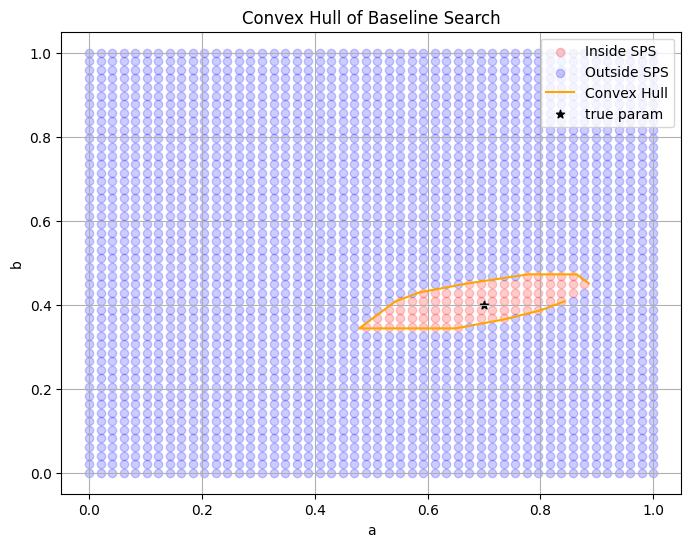

In [ ]:
# Hull code
baseline_hull = ConvexHull(baseline_in)
baseline_expanded = expand_convex_hull(baseline_in[baseline_hull.vertices])

# Plot the baseline hull
plt.figure(figsize=(8, 6))
if len(baseline_in):
    plt.scatter(baseline_in[:, 0], baseline_in[:, 1], color='red', label='Inside SPS', alpha=0.2)
if len(baseline_out):
    plt.scatter(baseline_out[:, 0], baseline_out[:, 1], color='blue', label='Outside SPS', alpha=0.2)
plt.plot(baseline_expanded[:,0], baseline_expanded[:,1], color='orange', label="Convex Hull")
plt.scatter(center[0], center[1], color='black', marker='*', label='true param')
plt.xlabel("a")
plt.ylabel("b")
plt.title("Convex Hull of Baseline Search")
plt.legend()
plt.grid(True)
plt.savefig("figures/sps_baseline_hull.png")
plt.show()

# Compare two hulls
# https://github.com/mhdadk/sutherland-hodgman





# KNN Benchmark

In [ ]:
# Measure of 'goodness' of confidence region approximation against a baseline
# Calculate the area of the intersection


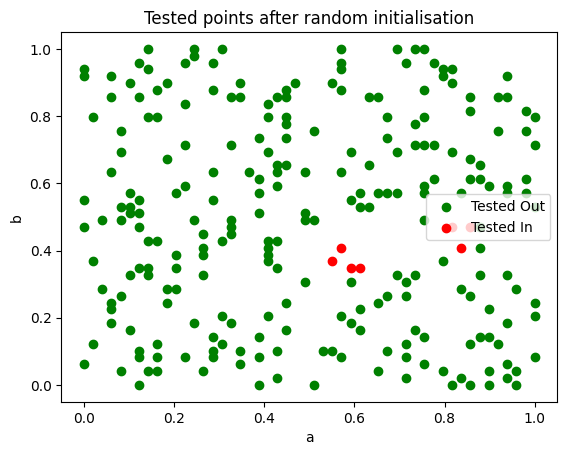

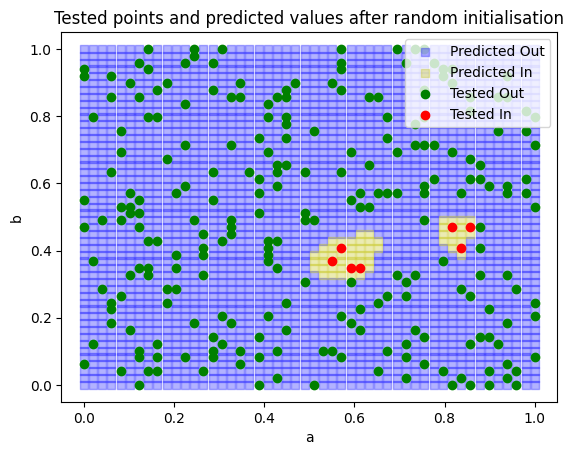

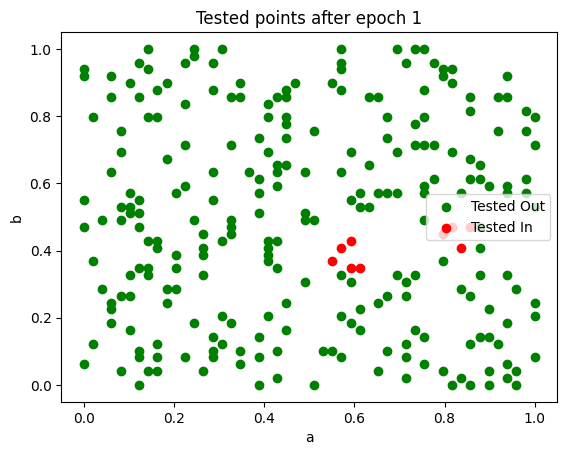

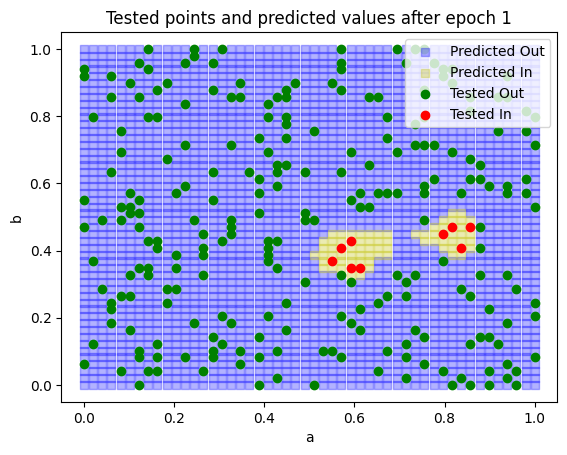

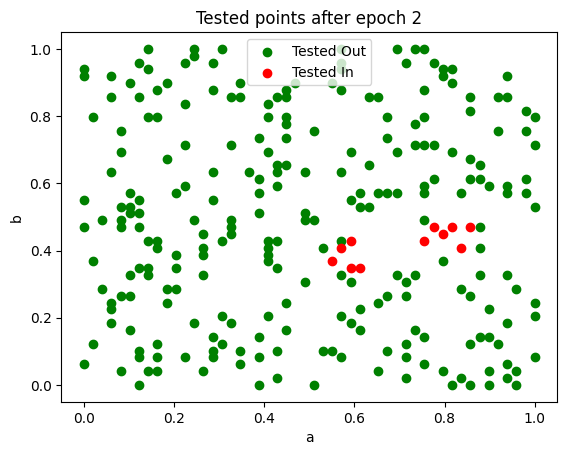

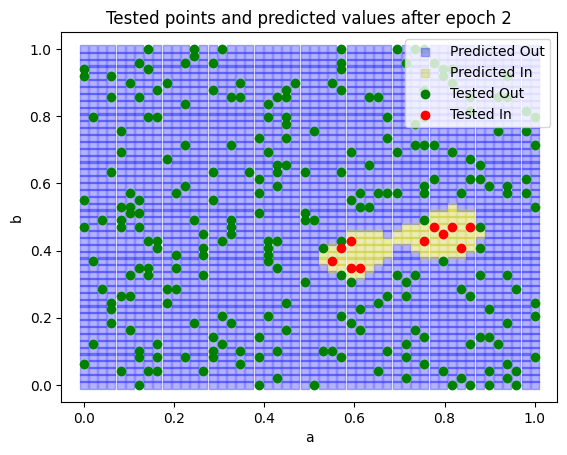

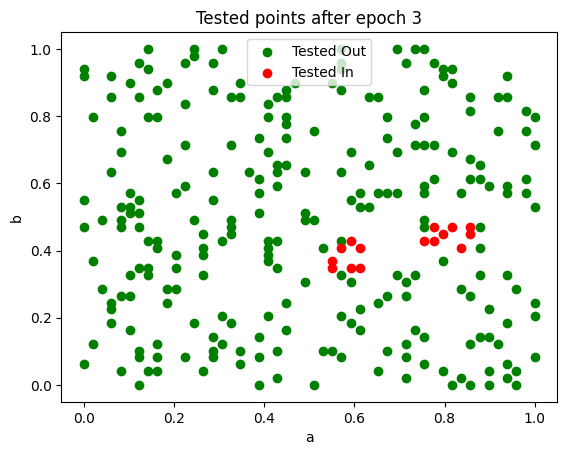

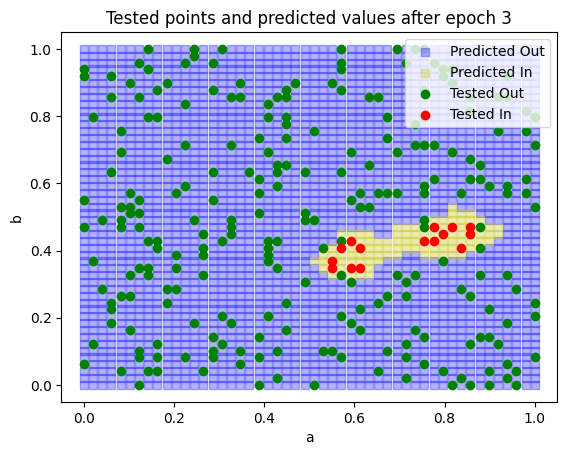

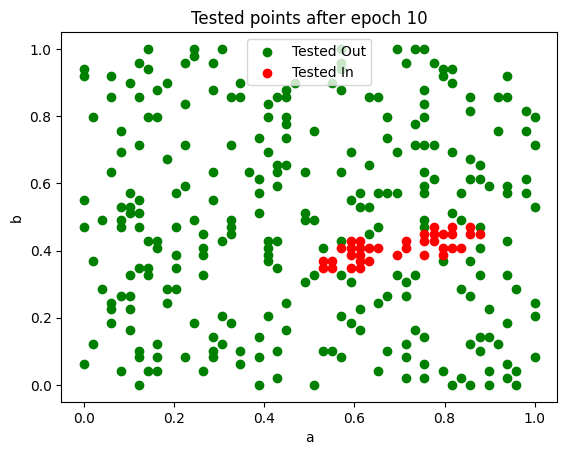

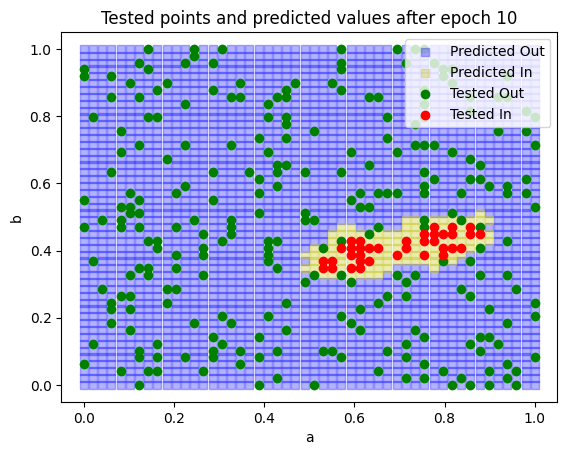

Total SPS calls:  370


In [ ]:
n_sps_calls = 0

def search_test_function(coord):
    global n_sps_calls
    n_sps_calls += 1
    return sps_test_function(coord, F=armax_model.F, L=armax_model.L, U=U, Y=Y, n_a = len(armax_model.A) - 1, n_b = len(armax_model.B))


n_params = len(armax_model.A) - 1 + len(armax_model.B)


search = SPSSearch(
        mins=[0]*n_params,
        maxes=[1]*n_params,
        n_dimensions=n_params,
        n_points=[50]*n_params,
        search_size=0.05,
        test_cb=search_test_function,
    )
search.go()

search.plot_epoch(0)
search.plot_epoch(1)
search.plot_epoch(2)
search.plot_epoch(3)
search.plot_epoch(10)
print("Total SPS calls: ", n_sps_calls)

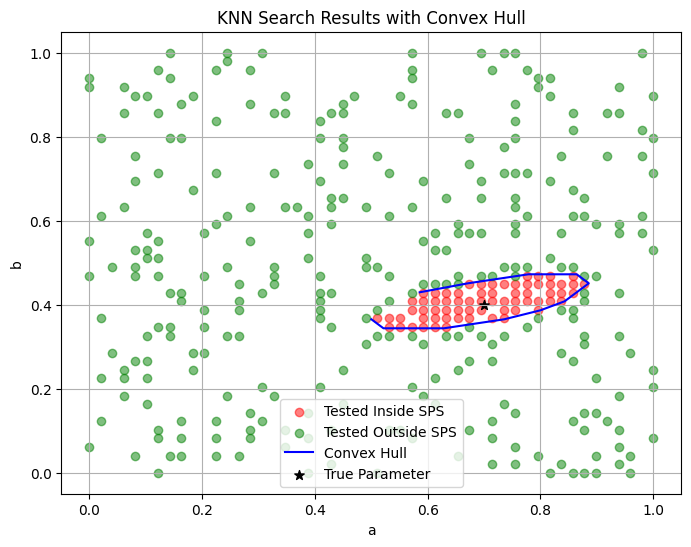

In [ ]:
knn_output = np.array(search.get_mapped_output())
knn_in = knn_output[knn_output[:,2] == True]
knn_in = knn_in[:,0:2]
knn_out = knn_output[knn_output[:,2] == False]

knn_hull = ConvexHull(knn_in)
knn_expanded = expand_convex_hull(knn_in[knn_hull.vertices])

knn_intersection = compare_hulls(baseline_expanded[::-1], knn_expanded[::-1])

union_list = np.concatenate([baseline_in, knn_in])
knn_union = ConvexHull(union_list)
union_points = union_list[knn_union.vertices]

# Plot the knn hull
plt.figure(figsize=(8, 6))
if len(knn_in):
    plt.scatter(knn_in[:, 0], knn_in[:, 1], color='red', label='Tested Inside SPS', alpha=0.5)
if len(knn_out):
    plt.scatter(knn_out[:, 0], knn_out[:, 1], color='green', label='Tested Outside SPS', alpha=0.5)
plt.plot(knn_expanded[:,0], knn_expanded[:,1], color='blue', label="Convex Hull")
plt.scatter(center[0], center[1], color='black', marker='*', label='True Parameter', s=50)
plt.xlabel("a")
plt.ylabel("b")
plt.title("KNN Search Results with Convex Hull")
plt.legend()
plt.grid(True)
plt.savefig("figures/knn_search_hull.png")
plt.show()




IoU = 0.997


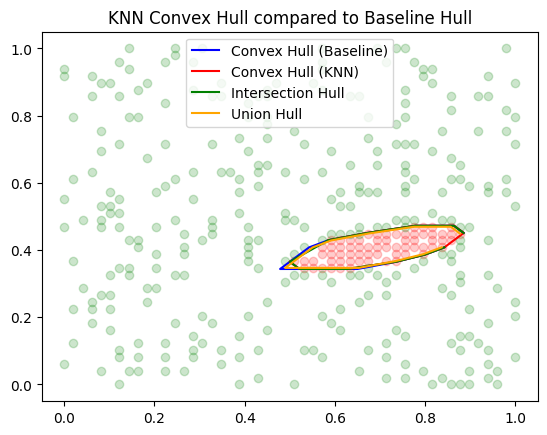

In [ ]:
# Hull Comparison
plt.figure()
if len(knn_in):
    plt.scatter(knn_in[:, 0], knn_in[:, 1], color='red', alpha=0.2)
if len(knn_out):
    plt.scatter(knn_out[:, 0], knn_out[:, 1], color='green', alpha=0.2)
plt.plot(baseline_expanded[:,0], baseline_expanded[:,1], color='blue', label="Convex Hull (Baseline)")
plt.plot(knn_expanded[:,0], knn_expanded[:,1], color='red', label="Convex Hull (KNN)")
plt.plot(knn_intersection[:,0], knn_intersection[:,1], color='green', label="Intersection Hull")
plt.plot(union_points[:,0], union_points[:,1], color='orange', label="Union Hull")
plt.title("KNN Convex Hull compared to Baseline Hull")
plt.savefig("figures/knn_search_hull_comparison.png")
plt.legend()

knn_union_area = knn_union.area
knn_intersection_area = ConvexHull(knn_intersection).area

print("IoU = %.3f" % (knn_intersection_area / knn_union_area))


In [ ]:
# Radial Search
from search.search_radial import RadialSearch

def test_ls(params, U, Y, armax_model, n_a, n_b):
    """
        params: vector of parameters to test
        K:      gain of the controller for this test run. Currently assumed to be constant
        U: U_t signal
        Y: Y_t signal
    """
    if False:
        print(f"Calculating loss with params {params}")
        [print(f"Number of inputs: {len(U)}")]
        [print(f"Number of outputs: {len(Y)}")]

    params = list(params)
    a = []
    b = []
    for _ in range(n_a):
        a.append(params.pop(0))

    for _ in range(n_b):
        b.append(params.pop(0))


    A = [1, *a]
    B = [0, *b]
    C = [1]

    G = d_tfs((B, A))
    H = d_tfs((C,A))


    L = d_tfs((armax_model.L, [1]))
    F = d_tfs((armax_model.F, [1]))

    model = SPS_indirect_model(1,1) # Dummy model for open_loop

    G_0, H_0 = G, H
    if F != [0] and F != 0:
        G_0, H_0 = model.transform_to_open_loop(G, H, F, L, supress_stability=True)

    YGU = Y - G_0 * U
    N_hat = (1/H_0) * YGU

    ret_val = np.sum([N_hat**2])  # Return SSE
    if False:
        print(ret_val)
    return ret_val

def get_lse(U, Y, armax_model, n_a, n_b):
    x0 = np.zeros( (n_a + n_b)) #  + np.random.randn(n_a + n_b)
    res = optimize.least_squares(test_ls, x0, args=(U, Y, armax_model, n_a, n_b))

    params_ls = res.x
    return params_ls

def test_radial(armax_model: ARMAX, n_vectors):
    n_a = len(armax_model.A) - 1
    n_b = len(armax_model.B)
    n_dim = n_a + n_b

    # Initialise the system
    R = signal.square(np.linspace(0, 10*np.pi, n_samples))
    Y, U, N, R = armax_model.simulate(n_samples, R, noise_std=0.1)

    # Wraper function for calling SPS algorithm with model parameters
    def test_wrapper ( coords):
        global n_sps_calls
        n_sps_calls += 1    # Increment the call count

        return sps_test_function( tuple(coords), armax_model.F, armax_model.L, U, Y, n_a, n_b)

    # Calculate the LSE
    lse = get_lse(U, Y, armax_model, n_a, n_b )



    search = RadialSearch(n_dim=n_dim,
                            n_vectors=n_vectors,
                            center=lse,
                            sps_test_function=test_wrapper)


    return lse, *search.search()

n_random_vectors = 100

lse, radial_ins, radial_outs, boundaries, hull, radial_expanded_hull = test_radial(OpenLoop1, n_vectors=n_random_vectors)
print("Average SPS calls per angle: %.2f" % ((len(radial_ins) + len(radial_outs)) / n_random_vectors))
print("Total SPS calls: %d" % (len(radial_ins) + len(radial_outs)))


radial_intersection = compare_hulls(baseline_expanded[::-1], radial_expanded_hull[::-1])
radial_intersection_hull = ConvexHull(radial_intersection)

union_list = np.concatenate([baseline_in, radial_ins])
radial_union = ConvexHull(union_list)
union_points = union_list[radial_union.vertices]

radial_area_u = radial_union.area
radial_area_i = radial_intersection_hull.area
radial_score = radial_area_i / radial_area_u
print("IoU: %.3f" % radial_score)

Average SPS calls per angle: 5.10
Total SPS calls: 510
IoU: 0.680


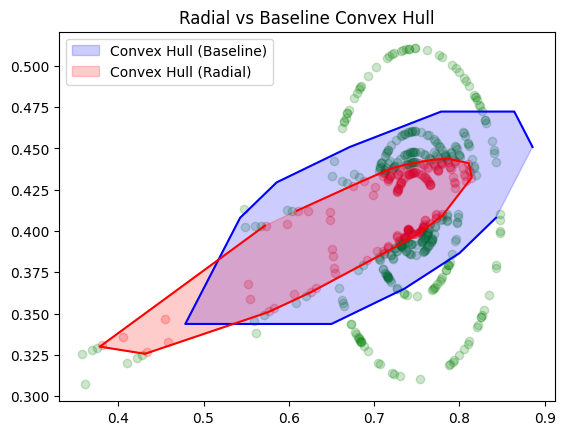

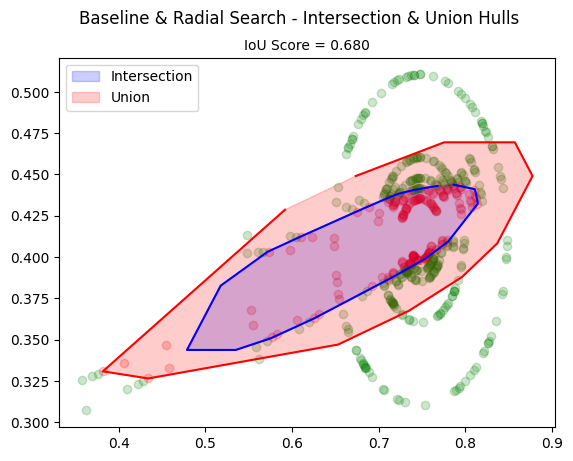

In [ ]:
# Hull Comparison
plt.figure()
if len(radial_ins):
    plt.scatter(radial_ins[:, 0], radial_ins[:, 1], color='red', alpha=0.2)
if len(radial_outs):
    plt.scatter(radial_outs[:, 0], radial_outs[:, 1], color='green', alpha=0.2)
plt.fill(baseline_expanded[:,0], baseline_expanded[:,1], color='blue', label="Convex Hull (Baseline)", alpha=0.2)
plt.plot(baseline_expanded[:,0], baseline_expanded[:,1], color='blue')
plt.fill(radial_expanded_hull[:,0], radial_expanded_hull[:,1], color='red', label="Convex Hull (Radial)", alpha=0.2)
plt.plot(radial_expanded_hull[:,0], radial_expanded_hull[:,1], color='red')
plt.title("Radial vs Baseline Convex Hull")
plt.savefig("figures/radial_baseline_hull.png")
plt.legend()



plt.figure()
if len(radial_ins):
    plt.scatter(radial_ins[:, 0], radial_ins[:, 1], color='red', alpha=0.2)
if len(radial_outs):
    plt.scatter(radial_outs[:, 0], radial_outs[:, 1], color='green', alpha=0.2)
plt.fill(radial_intersection[:,0], radial_intersection[:,1], color='blue', label="Intersection", alpha=0.2)
plt.plot(radial_intersection[:,0], radial_intersection[:,1], color='blue')
plt.fill(union_points[:,0], union_points[:,1], color='red', label="Union", alpha=0.2)
plt.plot(union_points[:,0], union_points[:,1], color='red')


plt.title("IoU Score = %.3f" % radial_score, fontsize=10)
plt.suptitle("Baseline & Radial Search - Intersection & Union Hulls")
plt.savefig("figures/radial_baseline_iou.png")
plt.legend()